In [4]:
import keras
import keras as keras
import numpy as np
import pandas as pd
import pytse_client as tse
import scipy.stats as stt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split


In [5]:
overall = tse.download_financial_indexes(symbols="شاخص كل", write_to_csv=True)

In [6]:
overall = overall['شاخص كل']
overall

,value,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08
...,...,...
3389,1469933.2,2022-12-17
3390,1500241.8,2022-12-18
3391,1500908.6,2022-12-19
3392,1492095.1,2022-12-20


In [7]:
overall_weight = tse.download_financial_indexes(symbols="شاخص كل (هم وزن)", write_to_csv=True)


In [8]:
overall_weight = overall_weight['شاخص كل (هم وزن)']
overall_weight

,value,date
0,10000.0,2014-03-19
1,10033.6,2014-03-25
2,9998.3,2014-03-26
3,9984.4,2014-03-29
4,10055.5,2014-03-30
...,...,...
2110,436478.0,2022-12-17
2111,443961.0,2022-12-18
2112,443305.0,2022-12-19
2113,442398.0,2022-12-20


In [9]:
overall.shape, overall_weight.shape

((3394, 2), (2115, 2))

In [10]:
overall = overall.iloc[-overall_weight.shape[0]:, :]
overall

,value,date
1279,79015.4,2014-03-19
1280,79013.5,2014-03-25
1281,78619.4,2014-03-26
1282,78239.7,2014-03-29
1283,78469.2,2014-03-30
...,...,...
3389,1469933.2,2022-12-17
3390,1500241.8,2022-12-18
3391,1500908.6,2022-12-19
3392,1492095.1,2022-12-20


In [11]:
overall_weight.iloc[0, 0]

10000.0

In [12]:
data = []

# add first row :) handy
row = [overall.iloc[0, 0], overall_weight.iloc[0, 0], 1]
data.append(row)

for i in range(1, overall_weight.shape[0]):
    row = []
    row.append(overall.iloc[i, 0])
    row.append(overall_weight.iloc[i, 0])
    row.append(1 if overall.iloc[i, 0] > overall.iloc[i - 1, 0] else 0)
    data.append(row)

# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Overall', 'Overall_weight', 'Result'])

# print dataframe.
df

,Overall,Overall_weight,Result
0,79015.4,10000.0,1
1,79013.5,10033.6,0
2,78619.4,9998.3,0
3,78239.7,9984.4,0
4,78469.2,10055.5,1
...,...,...,...
2110,1469933.2,436478.0,0
2111,1500241.8,443961.0,1
2112,1500908.6,443305.0,1
2113,1492095.1,442398.0,0


In [13]:
# apply normalization techniques
for column in ['Overall', 'Overall_weight']:
    df[column] = (df[column] -
                  df[column].min()) / df[column].std()
df

,Overall,Overall_weight,Result
0,0.030085,0.005097,1
1,0.030081,0.005287,0
2,0.029417,0.005087,0
3,0.028777,0.005008,0
4,0.029164,0.005411,1
...,...,...,...
2110,2.374124,2.418356,0
2111,2.425201,2.460699,1
2112,2.426325,2.456987,1
2113,2.411472,2.451854,0


# A

In [34]:
data = df.to_numpy()

In [35]:
data = df.to_numpy()

data_window = np.array([])
# data_window = []
lag = 20

for i in range(lag + 1, data.shape[0]):
    data_window = np.append(data_window, data[i - lag - 1: i - 1, 0:2])
    # data_window.append(data[i-lag-1 : i-1 , : ])

data_window = np.array(data_window)
data_window

array([0.03008451, 0.00509668, 0.03008131, ..., 2.46069881, 2.42632474,
       2.45698678])

In [36]:
data_window.shape

(83760,)

In [37]:
data_X = data_window.reshape((-1, 2, lag))
data_X

array([[[0.03008451, 0.00509668, 0.03008131, ..., 0.00537848,
         0.02806575, 0.00577571],
        [0.02740244, 0.00549674, 0.02584848, ..., 0.00395648,
         0.02455657, 0.00405833]],

       [[0.03008131, 0.00528681, 0.02941715, ..., 0.00577571,
         0.02740244, 0.00549674],
        [0.02584848, 0.00502142, 0.02318393, ..., 0.00405833,
         0.02496996, 0.0040074 ]],

       [[0.02941715, 0.00508706, 0.02877727, ..., 0.00549674,
         0.02584848, 0.00502142],
        [0.02318393, 0.00429316, 0.0215875 , ..., 0.0040074 ,
         0.02736907, 0.00491674]],

       ...,

       [[2.26406687, 2.22809731, 2.27075848, ..., 2.28615431,
         2.28613113, 2.28561109],
        [2.28633268, 2.29167709, 2.27919617, ..., 2.40299263,
         2.37412356, 2.41835567]],

       [[2.27075848, 2.23723591, 2.26916794, ..., 2.28561109,
         2.28633268, 2.29167709],
        [2.27919617, 2.29441018, 2.27211763, ..., 2.41835567,
         2.42520102, 2.46069881]],

       [[2.269167

In [38]:
data_y = data[lag + 1:, 2]
data_y = data_y.astype(int)
data_y

array([1, 1, 1, ..., 1, 0, 1])

In [39]:
data_X.shape, data_y.shape

((2094, 2, 20), (2094,))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1779, 2, 20), (315, 2, 20), (1779,), (315,))

In [91]:
def report_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['test', 'train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

# B

Simple RNN

In [106]:
model = keras.Sequential([
    layers.InputLayer((2, lag)),
    # layers.SimpleRNN(lag,return_sequences=True),
    layers.SimpleRNN(lag ,activation='relu'),
    # layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 20)                820       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_58 (Dense)            (None, 32)                672       
                                                                 
 dense_59 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,525
Trainable params: 1,525
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=4, epochs=40, validation_split=0.1)

Epoch 1/40
401/401 [==============================] - 4s 8ms/step - loss: 0.6901 - accuracy: 0.5778 - val_loss: 0.6820 - val_accuracy: 0.6124
Epoch 2/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6828 - accuracy: 0.5790 - val_loss: 0.6680 - val_accuracy: 0.5899
Epoch 3/40
401/401 [==============================] - 3s 8ms/step - loss: 0.6775 - accuracy: 0.5778 - val_loss: 0.6904 - val_accuracy: 0.6124
Epoch 4/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6811 - accuracy: 0.5840 - val_loss: 0.6727 - val_accuracy: 0.6124
Epoch 5/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6771 - accuracy: 0.5890 - val_loss: 0.6989 - val_accuracy: 0.6124
Epoch 6/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6769 - accuracy: 0.5859 - val_loss: 0.6686 - val_accuracy: 0.6124
Epoch 7/40
401/401 [==============================] - 3s 8ms/step - loss: 0.6767 - accuracy: 0.5878 - val_loss: 0.6583 - val_accuracy: 0.6180
Epoch 

In [108]:
pred = model.predict(X_test)
pred

array([[0.5662891 ],
       [0.63482565],
       [0.6508015 ],
       [0.5993525 ],
       [0.41201982],
       [0.5926616 ],
       [0.6147198 ],
       [0.5478291 ],
       [0.56693727],
       [0.5804028 ],
       [0.60421115],
       [0.6473953 ],
       [0.4236881 ],
       [0.55954456],
       [0.65590245],
       [0.574196  ],
       [0.55647224],
       [0.6623419 ],
       [0.5693415 ],
       [0.55585873],
       [0.6688823 ],
       [0.61559784],
       [0.64927983],
       [0.5739106 ],
       [0.61015975],
       [0.5771579 ],
       [0.61514443],
       [0.5589315 ],
       [0.56196916],
       [0.64245236],
       [0.6395199 ],
       [0.53477645],
       [0.63645804],
       [0.4785864 ],
       [0.5875762 ],
       [0.5430075 ],
       [0.5733274 ],
       [0.64861673],
       [0.6024705 ],
       [0.55719304],
       [0.60330725],
       [0.650757  ],
       [0.6607607 ],
       [0.6392688 ],
       [0.5241394 ],
       [0.5561064 ],
       [0.596635  ],
       [0.660

In [109]:
pred = [0 if row < 0.50 else 1 for row in pred]

In [110]:
accuracy_score(y_test, pred)

0.5682539682539682

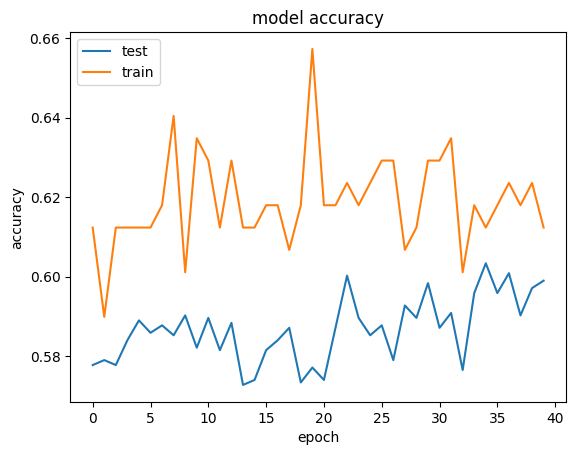

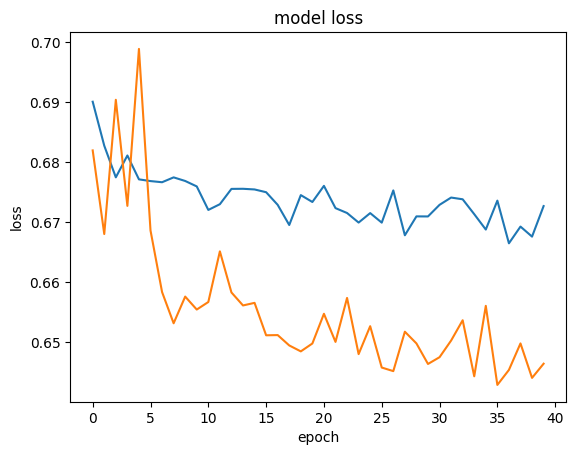

In [111]:
report_history(history)

LSTM

In [112]:
model = None
model = Sequential()
model.add(layers.InputLayer((2, lag)))
model.add(layers.LSTM(lag))
# model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_18 (Dropout)        (None, 20)                0         
                                                                 
 dense_60 (Dense)            (None, 32)                672       
                                                                 
 dense_61 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=4, epochs=40, validation_split=0.1)

Epoch 1/40
401/401 [==============================] - 4s 8ms/step - loss: 0.6827 - accuracy: 0.5746 - val_loss: 0.6609 - val_accuracy: 0.6124
Epoch 2/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6752 - accuracy: 0.5790 - val_loss: 0.6612 - val_accuracy: 0.6067
Epoch 3/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6729 - accuracy: 0.5834 - val_loss: 0.6520 - val_accuracy: 0.6236
Epoch 4/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6741 - accuracy: 0.5846 - val_loss: 0.6540 - val_accuracy: 0.6011
Epoch 5/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6722 - accuracy: 0.5821 - val_loss: 0.6536 - val_accuracy: 0.6180
Epoch 6/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6741 - accuracy: 0.5821 - val_loss: 0.6504 - val_accuracy: 0.6011
Epoch 7/40
401/401 [==============================] - 3s 7ms/step - loss: 0.6711 - accuracy: 0.5928 - val_loss: 0.6517 - val_accuracy: 0.6180
Epoch 

In [114]:
pred = model.predict(X_test)
pred

array([[0.5548085 ],
       [0.7676764 ],
       [0.6407586 ],
       [0.5441791 ],
       [0.5054787 ],
       [0.49457183],
       [0.5939601 ],
       [0.46569288],
       [0.5508591 ],
       [0.5193939 ],
       [0.59123677],
       [0.7907693 ],
       [0.50964075],
       [0.54337835],
       [0.64428645],
       [0.5007598 ],
       [0.5406937 ],
       [0.6515357 ],
       [0.54054654],
       [0.45546758],
       [0.8156539 ],
       [0.5954997 ],
       [0.77248174],
       [0.54106945],
       [0.58010393],
       [0.5117981 ],
       [0.594159  ],
       [0.54093695],
       [0.54041535],
       [0.6150998 ],
       [0.54228437],
       [0.47043964],
       [0.7847693 ],
       [0.53799534],
       [0.49195546],
       [0.55414075],
       [0.47856057],
       [0.71658254],
       [0.5884522 ],
       [0.46536407],
       [0.5940162 ],
       [0.6383573 ],
       [0.64836377],
       [0.5433199 ],
       [0.564045  ],
       [0.48285654],
       [0.59674186],
       [0.648

In [115]:
pred = [0 if row < 0.50 else 1 for row in pred]

In [116]:
accuracy_score(y_test, pred)

0.5936507936507937

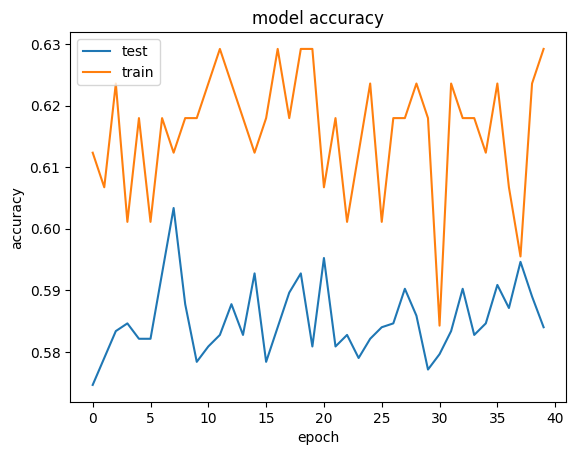

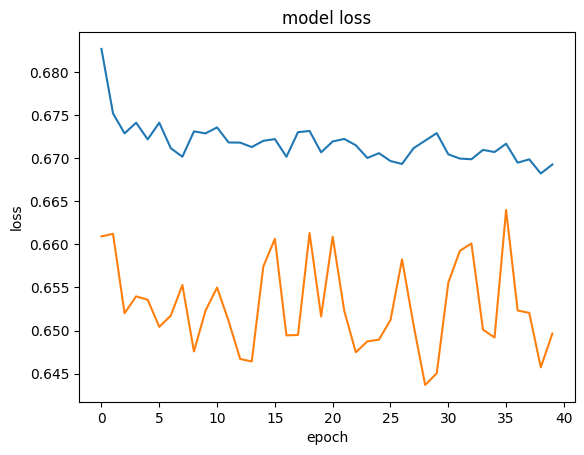

In [117]:
report_history(history)

# C

In [127]:
data_X.shape, data_y.shape

((2094, 2, 20, 1), (2094,))

In [128]:
data_X = data_X.reshape((data_X.shape[0], data_X.shape[1], data_X.shape[2], 1))
data_X.shape

(2094, 2, 20, 1)

In [129]:

model = None
model = keras.Sequential([
    layers.Conv2D(8, (2, 2), activation='relu', input_shape=(2, lag, 1)),
    layers.MaxPooling2D(pool_size=(1, 2)),
    layers.Conv2D(16, (1, 3), activation='relu'),
    # # layers.MaxPooling2D(),
    # layers.Conv2D(32, 2, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Flatten(),
    # layers.Dense(124, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()



Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 19, 8)          40        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 9, 8)          0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 7, 16)          400       
                                                                 
 flatten_2 (Flatten)         (None, 112)               0         
                                                                 
 dropout_20 (Dropout)        (None, 112)               0         
                                                                 
 dense_64 (Dense)            (None, 32)                3616      
                                                     

In [130]:
# model.compile(optimizer="Adam", loss='mean_squared_error',
#               metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=4, epochs=40, validation_split=0.1)


Epoch 1/40
401/401 [==============================] - 2s 5ms/step - loss: 0.6849 - accuracy: 0.5765 - val_loss: 0.6668 - val_accuracy: 0.6124
Epoch 2/40
401/401 [==============================] - 2s 4ms/step - loss: 0.6777 - accuracy: 0.5778 - val_loss: 0.6615 - val_accuracy: 0.6180
Epoch 3/40
401/401 [==============================] - 2s 4ms/step - loss: 0.6770 - accuracy: 0.5790 - val_loss: 0.6589 - val_accuracy: 0.6124
Epoch 4/40
401/401 [==============================] - 2s 4ms/step - loss: 0.6759 - accuracy: 0.5878 - val_loss: 0.6605 - val_accuracy: 0.6180
Epoch 5/40
401/401 [==============================] - 2s 4ms/step - loss: 0.6758 - accuracy: 0.5896 - val_loss: 0.6575 - val_accuracy: 0.5955
Epoch 6/40
401/401 [==============================] - 2s 4ms/step - loss: 0.6756 - accuracy: 0.5784 - val_loss: 0.6589 - val_accuracy: 0.6629
Epoch 7/40
401/401 [==============================] - 2s 4ms/step - loss: 0.6757 - accuracy: 0.5834 - val_loss: 0.6639 - val_accuracy: 0.6573
Epoch 

In [131]:
pred = model.predict(X_test)
pred

array([[0.48442334],
       [0.6779541 ],
       [0.59912604],
       [0.59591216],
       [0.5964088 ],
       [0.48786202],
       [0.5966766 ],
       [0.4689171 ],
       [0.48031503],
       [0.49205738],
       [0.5963791 ],
       [0.6839655 ],
       [0.59591186],
       [0.47885036],
       [0.59946746],
       [0.48277113],
       [0.59591216],
       [0.5989864 ],
       [0.59591216],
       [0.44609094],
       [0.7100109 ],
       [0.59717745],
       [0.6786496 ],
       [0.59591216],
       [0.6232825 ],
       [0.4974333 ],
       [0.60363585],
       [0.59591216],
       [0.59591216],
       [0.5979983 ],
       [0.59591216],
       [0.46941036],
       [0.6779193 ],
       [0.59591216],
       [0.49965048],
       [0.6296908 ],
       [0.48775584],
       [0.65912575],
       [0.5967658 ],
       [0.46957427],
       [0.6002921 ],
       [0.59925133],
       [0.598638  ],
       [0.59591216],
       [0.5968638 ],
       [0.48182544],
       [0.6001667 ],
       [0.598

In [132]:
pred = [0 if row < 0.50 else 1 for row in pred]

In [133]:
pred

[0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,


In [134]:
accuracy_score(y_test, pred)

0.5873015873015873

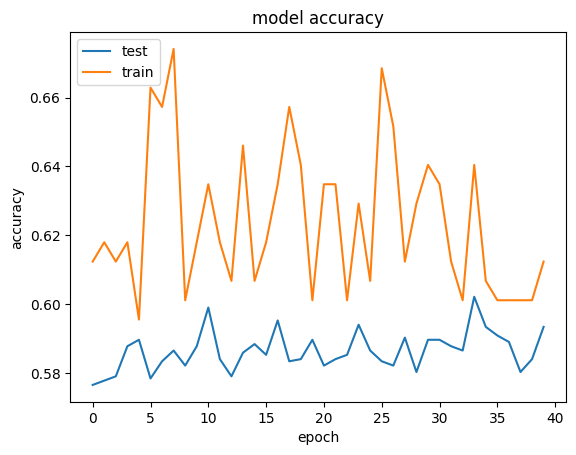

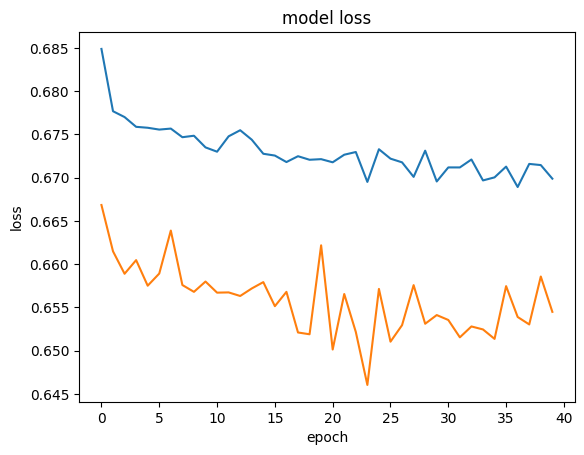

In [135]:
report_history(history)